In [ ]:
# 获取授权
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
import os
os.chdir("drive/my_scripts") 

In [ ]:
# 云端默认没有face_recognition
!pip install face_recognition

In [ ]:
!ls
!nvidia-smi
!python --version

In [166]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.optim
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
import argparse
import time
# 用于重新加载模块
import importlib

import networks.ACNN as net_ACNN
importlib.reload(net_ACNN)
ACNN = net_ACNN.ACNN
import networks.ACCNN as net_ACCNN
importlib.reload(net_ACCNN)
ACCNN = net_ACCNN.ACCNN
from networks.AlexNet import AlexNet
from networks.VGG import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn
from networks.ResNet import resnet18, resnet34, resnet50, resnet101, resnet152
import dal.JAFFE_DataSet as JAFFE_DataSet
import dal.CKPlus_DataSet as CKPlus_DataSet
import dal.FER2013_DataSet as FER2013_DataSet
# importlib.reload(JAFFE_DataSet)
# importlib.reload(CKPlus_DataSet)
# importlib.reload(FER2013_DataSet)
JAFFE = JAFFE_DataSet.JAFFE
CKPlus = CKPlus_DataSet.CKPlus
FER2013 = FER2013_DataSet.FER2013
import transforms.transforms as transforms
import utils.utils as utils
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")  # 让torch判断是否使用GPU，建议使用GPU环境，因为会快很多
print('cuda available: ', use_cuda)
print('using DEVICE: ', DEVICE)
enabled_nets = ["ACNN", "ACCNN", "AlexNet", "VGG11", "VGG13", "VGG16", "VGG19", "ResNet18", "ResNet34", "ResNet50",
                "ResNet101", "ResNet152"]
enabled_datasets = ["JAFFE", "CK+", "FER2013"]

cuda available:  True
using DEVICE:  cuda


In [190]:
class OPT:
    def __init__(self):
        # Other Parameters
        # 是否使用面部标记点进行训练
        self.fl = True
        # 存储的模型序号
        self.save_number = 5
        # 批次大小
        self.bs = 32
        # 学习率
        self.lr = 0.01
        # epoch
        self.epoch = 200
        # 每次获得到更优的准确率后，会进行一次存储，此选项选择是否从上次存储位置继续
        self.resume = True
        # 表示一开始的lrd_je个epoch，lr增大来解决一开始的收敛缓慢问题
        self.lre_je = 20
        # 表示默认从第 $lrd_se 次epoch开始进行lr的递减
        self.lrd_se = 180
        # 表示默认每经过2次epoch进行一次递减
        self.lrd_s = 2
        # 表示每次的lr的递减率，默认每递减一次乘一次0.9
        self.lrd_r = 0.9
        
#         self.model, self.epoch, self.bs = 'ACNN', 1000, 128
        self.model, self.epoch, self.bs = 'ACCNN', 2000, 64
#         self.model, self.epoch, self.bs = 'AlexNet', 500, 32
#         self.model, self.epoch, self.bs = 'VGG11', 200, 32
#         self.model, self.epoch, self.bs = 'VGG13', 200, 32
#         self.model, self.epoch, self.bs = 'VGG16', 200, 32
#         self.model, self.epoch, self.bs = 'VGG19', 200, 32
#         self.model, self.epoch, self.bs = 'ResNet18', 200, 32
#         self.model, self.epoch, self.bs = 'ResNet34', 200, 32
#         self.model, self.epoch, self.bs = 'ResNet50', 200, 32
#         self.model, self.epoch, self.bs = 'ResNet101', 200, 32
#         self.model, self.epoch, self.bs = 'ResNet152', 200, 32
        self.lre_je = int(self.epoch*0.1)
        self.lrd_se = 1750
        self.lrd_s = 20
        
#         self.dataset = 'FER2013'
#         self.dataset = 'JAFFE'
        self.dataset = 'CK+'
opt = OPT()


train_acc_map = {'best_acc': 0, 'best_acc_epoch': -1, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
test_acc_map = {'best_acc': 0, 'best_acc_epoch': -1, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Train_acc, Test_acc = 0., 0.

In [173]:
reset_dataset = False
if reset_dataset:
    criterion, target_type = nn.CrossEntropyLoss(), 'ls'
    print("------------Preparing Data...----------------")
    if opt.dataset == "JAFFE":
        train_data = JAFFE(is_train=True, transform=None, target_type=target_type, using_fl=opt.fl)
        test_data = JAFFE(is_train=False, transform=None, target_type=target_type, using_fl=opt.fl)
    elif opt.dataset == "CK+":
        train_data = CKPlus(is_train=True, transform=None, target_type=target_type, using_fl=opt.fl)
        test_data = CKPlus(is_train=False, transform=None, target_type=target_type, using_fl=opt.fl)
    elif opt.dataset == "FER2013":
        train_data = FER2013(is_train=True, private_test=True, transform=None, target_type=target_type,
                             using_fl=opt.fl)
        test_data = FER2013(is_train=False, private_test=True, transform=None, target_type=target_type,
                            using_fl=opt.fl)
    else:
        assert("opt.dataset should be in %s, but got %s" % (enabled_datasets, opt.dataset))
    print("------------%s Data Already be Prepared------------" % opt.dataset)

------------Preparing Data...----------------
train_num:  906  test_num: 75
train_num:  906  test_num: 75
------------CK+ Data Already be Prepared------------


In [191]:
n_classes = 7
net_to_save_dir = "Saved_Models"
net_to_save_path = os.path.join(net_to_save_dir, str(opt.save_number), opt.dataset+'_'+opt.model+'_'+str(opt.save_number))
if opt.fl:
    saved_model_name = "Best_model_fl.t7"
    saved_temp_model_name = "Best_model_fl_temp.t7"
    model_over_flag_name = "__%d_success_fl__" % (opt.epoch)
    history_file_name = "history_fl.txt"
else:
    saved_model_name = "Best_model.t7"
    saved_temp_model_name = "Best_model_temp.t7"
    model_over_flag_name = "__%d_success__" % (opt.epoch)
    history_file_name = "history.txt"
over_flag = False  # 如果已经成功训练完，就可以结束了
TEMP_EPOCH = 2  # 用于暂时存储，每TEMP_EPOCH次存一次
temp_internal = TEMP_EPOCH

In [192]:
print("------------Preparing Model...----------------")
if opt.model.lower() == "ACNN".lower():
    net = ACNN(n_classes=n_classes).to(DEVICE)
elif opt.model.lower() == "ACCNN".lower():
    net = ACCNN(n_classes=n_classes).to(DEVICE)
elif opt.model.lower() == "AlexNet".lower():
    net = AlexNet(n_classes=n_classes).to(DEVICE)
elif opt.model.lower() == "VGG11".lower():
    net = vgg11_bn(n_classes=n_classes).to(DEVICE)
elif opt.model.lower() == "VGG13".lower():
    net = vgg13_bn(n_classes=n_classes).to(DEVICE)
elif opt.model.lower() == "VGG16".lower():
    net = vgg16_bn(n_classes=n_classes).to(DEVICE)
elif opt.model.lower() == "VGG19".lower():
    net = vgg19_bn(n_classes=n_classes).to(DEVICE)
elif opt.model.lower() == "ResNet18".lower():
    net = resnet18(n_classes=n_classes).to(DEVICE)
elif opt.model.lower() == "ResNet34".lower():
    net = resnet34(n_classes=n_classes).to(DEVICE)
elif opt.model.lower() == "ResNet50".lower():
    net = resnet50(n_classes=n_classes).to(DEVICE)
elif opt.model.lower() == "ResNet101".lower():
    net = resnet101(n_classes=n_classes).to(DEVICE)
elif opt.model.lower() == "ResNet152".lower():
    net = resnet152(n_classes=n_classes).to(DEVICE)
else:
    net = None
    assert("opt.model should be in %s, but got %s" % (enabled_nets, opt.model))
start_epoch = 0
if opt.resume:
    # Load checkpoint.
    print('==> Loading Model Parameters...')
    if os.path.exists(os.path.join(net_to_save_path, saved_temp_model_name)):
        if os.path.exists(os.path.join(net_to_save_path, model_over_flag_name)):
            print("Model trained over flag checked!")
            over_flag = True
        assert os.path.isdir(net_to_save_path), 'Error: no checkpoint directory found!'
        checkpoint = torch.load(os.path.join(net_to_save_path, saved_temp_model_name))
        net.load_state_dict(checkpoint['net'])
        test_acc_map['best_acc'] = checkpoint['best_test_acc']
        test_acc_map['best_acc_epoch'] = checkpoint['best_test_acc_epoch']
        start_epoch = checkpoint['cur_epoch'] + 1
    else:
        print("Checkout File not Found, No initialization.")
print("------------%s Model Already be Prepared------------" % opt.model)

# for gray images
IMG_MEAN = [0.449]
IMG_STD = [0.226]

crop_img_size = int(net.input_size*1.2)
input_img_size = net.input_size
transform_train = transforms.Compose([
    transforms.Resize(input_img_size),  # 缩放将图片的最小边缩放为 input_img_size，因此如果输入是非正方形的，那么输出也不是正方形的
#     transforms.Resize(crop_img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
#     transforms.Resize(test_img_size),
#     transforms.TenCrop(input_img_size),
#     transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.ToTensor(),
    transforms.Normalize(IMG_MEAN, IMG_STD),
])

test_img_size = int(input_img_size * 1.1)  # 测试时，图片resize大小
transform_test = transforms.Compose([
    transforms.Resize(input_img_size),  # 缩放将图片的最小边缩放为 input_img_size，因此如果输入是非正方形的，那么输出也不是正方形的
#     transforms.Resize(crop_img_size),
#     transforms.TenCrop(input_img_size),
#     transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.ToTensor(),
    transforms.Normalize(IMG_MEAN, IMG_STD),
])

# 随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=opt.lr, momentum=0.9, weight_decay=5e-4)

train_data.set_transform(transform_train)
test_data.set_transform(transform_test)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=opt.bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=opt.bs, shuffle=False)

------------Preparing Model...----------------
Initializing ACCNN weights...
Init ACCNN model over!
==> Loading Model Parameters...
------------ACCNN Model Already be Prepared------------


In [193]:
print(net)

ACCNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), dilation=(2, 2))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace)
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): ReLU(inplace)
    (11): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (17): ReLU(inplace)
    (18): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  

(1, 96, 96)


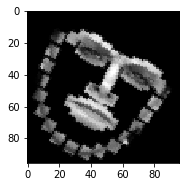

(1, 96, 96)


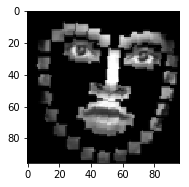

(1, 96, 96)


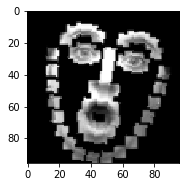

(1, 96, 96)


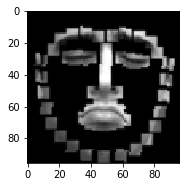

(1, 96, 96)


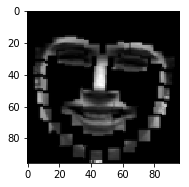

(1, 96, 96)


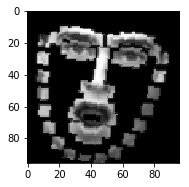

(1, 96, 96)


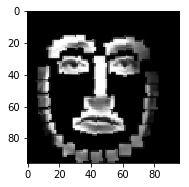

In [194]:
# 测试数据集输出的正确性
itr = enumerate(train_loader)
bs, (inputs, targets) = next(itr)
inputs, targets = inputs.numpy(), targets.numpy()
for index in range(len(inputs)):
    input = inputs[index]
    print(input.shape)
    arr = input.reshape([input.shape[1], input.shape[2]])
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.imshow(arr, cmap="gray")
    plt.show()
    if index > 5:
        break

In [195]:
# Training
def train(epoch, jump_out_lr=-1.):
    # 根据训练的epoch次数来降低learning rate
    if epoch >= opt.lrd_se > 0:
        frac = ((epoch - opt.lrd_se) // opt.lrd_s) + 1
        decay_factor = opt.lrd_r ** frac
        current_lr = opt.lr * decay_factor  # current_lr = opt.lr * 降低率 ^ ((epoch - 开始decay的epoch) // 每次decay的epoch num)
        utils.set_lr(optimizer, current_lr)  # set the learning rate
    else:
        current_lr = opt.lr
    if epoch < opt.lre_je:
        current_lr *= 1.5  # 解决一开始收敛慢的问题
    print('learning_rate: %s' % str(current_lr))
    global Train_acc
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    cur_train_acc = 0.
    time_start = time.time()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
#         bs, ncrops, c, h, w = np.shape(inputs)
#         inputs = inputs.view(-1, c, h, w)
        if use_cuda:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE, torch.long)
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        # print("outputs:", outputs)
        # print("targets:", targets)
        loss = criterion(outputs, targets)
        loss.backward()
        utils.clip_gradient(optimizer, 2*current_lr)  # 解决梯度爆炸 https://blog.csdn.net/u010814042/article/details/76154391
        optimizer.step()

        train_loss += float(loss.data)
        _, predicted = torch.max(outputs.data, 1)  # torch.max() 加上dim参数后，返回值为 max_value, max_value_index
        if target_type == 'ls':
            ground_value = targets.data
        elif target_type == 'fa':
            _, ground_value = torch.max(targets.data, 1)
        # print("predicted:", predicted)
        # print("ground_value:", ground_value)

        for i in range(len(predicted)):
            if predicted[i] == ground_value[i]:
                train_acc_map[predicted[i].item()] += 1

        total += targets.size(0)
        correct += predicted.eq(ground_value.data).cpu().sum()
        # print("equal: ", predicted.eq(ground_value.data).cpu())
        cur_train_acc = float(correct) / float(total) * 100.

        time_end = time.time()
        duration = time_end - time_start
        utils.progress_bar(batch_idx, len(train_loader), 'Time: %.2fs | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
                           (duration, train_loss / (batch_idx + 1), cur_train_acc, correct, total))

        # 删除无用的变量，释放显存
        del loss
        del inputs
        del outputs
        del predicted
    Train_acc = cur_train_acc
    if train_acc_map['best_acc'] < Train_acc:
        train_acc_map['best_acc'] = Train_acc
        train_acc_map['best_acc_epoch'] = epoch
    write_history('Train', epoch, cur_train_acc, train_loss / (batch_idx + 1), None)


# Testing
def test(epoch):
    global Test_acc
    private_test_loss = 0
    net.eval()
    correct = 0
    total = 0
    cur_test_acc = 0.
    correct_map = [0, 0, 0, 0, 0, 0, 0]
    time_start = time.time()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            bs, c, h, w = np.shape(inputs)
#             bs, ncrops, c, h, w = np.shape(inputs)
            inputs = inputs.view(-1, c, h, w)
            if use_cuda:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE, torch.long)
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)

            # avg over crops if test_transform contains crop operations
            # outputs_avg = outputs.view(bs, ncrops, -1).mean(1)
            outputs_avg = outputs

            loss = criterion(outputs_avg, targets)
            private_test_loss += float(loss.data)
            _, predicted = torch.max(outputs_avg.data, 1)
            if target_type == 'ls':
                ground_value = targets.data
            elif target_type == 'fa':
                _, ground_value = torch.max(targets.data, 1)

            for i in range(len(predicted)):
                if predicted[i] == ground_value[i]:
                    c = predicted[i].item()
                    test_acc_map[c] += 1
                    correct_map[c] += 1

            total += targets.size(0)
            correct += predicted.eq(ground_value.data).cpu().sum()
            cur_test_acc = float(correct) / float(total) * 100.

            time_end = time.time()
            duration = time_end - time_start
            utils.progress_bar(batch_idx, len(test_loader), 'Time: %.2fs | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
                               (duration, private_test_loss / (batch_idx + 1), cur_test_acc, correct, total))

            # 删除无用的变量，释放显存
            del loss
            del inputs
            del outputs
            del predicted

    Test_acc = cur_test_acc
    if test_acc_map['best_acc'] < Test_acc:
        test_acc_map['best_acc'] = Test_acc
        test_acc_map['best_acc_epoch'] = epoch
        print('Saving net to %s' % net_to_save_path)
        print('best_acc: %0.3f' % test_acc_map['best_acc'])
        print('correct_map: %s' % correct_map)
        state = {'net': net.state_dict() if use_cuda else net,
                 'best_test_acc': test_acc_map['best_acc'],
                 'best_test_acc_epoch': test_acc_map['best_acc_epoch'],
                 'cur_epoch': epoch,
                 'correct_map': correct_map,
                 }
        torch.save(state, os.path.join(net_to_save_path, saved_model_name))
    write_history('Test', epoch, cur_test_acc, private_test_loss / (batch_idx + 1), correct_map)
        

def write_history(train_or_test, epoch, acc, loss, predictions):
    with open(os.path.join(net_to_save_path, history_file_name), "a+", encoding="utf-8") as history_file:
        msg = train_or_test + " %d %.3f %.3f " % (epoch, acc, loss)
        if predictions:
            msg += str(predictions)
        msg += "\n"
        history_file.write(msg)
        history_file.flush()

def save_over_flag():
    file_path = os.path.join(net_to_save_path, model_over_flag_name)
    with open(file_path, "w+", encoding="utf-8") as file:
        file.write(train_acc_map.__str__())
        file.write("\n")
        file.write(test_acc_map.__str__())
        file.write("\n")
        file.flush()


In [196]:
if not os.path.isdir(net_to_save_dir):
    os.mkdir(net_to_save_dir)
if not os.path.isdir(os.path.join(net_to_save_dir, str(opt.save_number))):
    os.mkdir(os.path.join(net_to_save_dir, str(opt.save_number)))
if not os.path.isdir(net_to_save_path):
    os.mkdir(net_to_save_path)
if not over_flag:
    for epoch in range(start_epoch, opt.epoch, 1):
        print('\n------------Epoch: %d-------------' % epoch)
        train(epoch)
        test(epoch)
        temp_internal -= 1
        if temp_internal <= 0:
            temp_internal = TEMP_EPOCH
            print("Saving Temp Model...")
            state = {'net': net.state_dict() if use_cuda else net,
                 'best_test_acc': test_acc_map['best_acc'],
                 'best_test_acc_epoch': test_acc_map['best_acc_epoch'],
                 'cur_epoch': epoch,
                 }
            torch.save(state, os.path.join(net_to_save_path, saved_temp_model_name))
    print(train_acc_map)
    print(test_acc_map)
    save_over_flag()
print("Trained Over")


------------Epoch: 1214-------------
learning_rate: 0.01
[==============================>] | Time: 6.17s | Loss: 1.676 | Acc: 47.020% (426/906)
[==============================>] | Time: 0.18s | Loss: 1.528 | Acc: 37.333% (28/75)

------------Epoch: 1215-------------
learning_rate: 0.01
[==============================>] | Time: 6.09s | Loss: 1.697 | Acc: 47.241% (428/906)
[==============================>] | Time: 0.19s | Loss: 1.540 | Acc: 36.000% (27/75)
Saving Temp Model...

------------Epoch: 1216-------------
learning_rate: 0.01
[==============================>] | Time: 6.02s | Loss: 1.697 | Acc: 46.689% (423/906)
[==============================>] | Time: 0.18s | Loss: 1.539 | Acc: 36.000% (27/75)

------------Epoch: 1217-------------
learning_rate: 0.01
[==============================>] | Time: 6.04s | Loss: 1.716 | Acc: 44.481% (403/906)
[==============================>] | Time: 0.20s | Loss: 1.540 | Acc: 36.000% (27/75)
Saving Temp Model...

------------Epoch: 1218-------------


[==============================>] | Time: 5.97s | Loss: 1.500 | Acc: 66.115% (599/906)
[==============================>] | Time: 0.21s | Loss: 1.447 | Acc: 52.000% (39/75)
Saving Temp Model...

------------Epoch: 1248-------------
learning_rate: 0.01
[==============================>] | Time: 6.02s | Loss: 1.506 | Acc: 65.673% (595/906)
[==============================>] | Time: 0.19s | Loss: 1.448 | Acc: 52.000% (39/75)

------------Epoch: 1249-------------
learning_rate: 0.01
[==============================>] | Time: 6.01s | Loss: 1.503 | Acc: 67.108% (608/906)
[==============================>] | Time: 0.18s | Loss: 1.462 | Acc: 49.333% (37/75)
Saving Temp Model...

------------Epoch: 1250-------------
learning_rate: 0.01
[==============================>] | Time: 6.00s | Loss: 1.481 | Acc: 66.777% (605/906)
[==============================>] | Time: 0.19s | Loss: 1.447 | Acc: 52.000% (39/75)

------------Epoch: 1251-------------
learning_rate: 0.01
[==============================>] | Ti

[==============================>] | Time: 6.04s | Loss: 1.345 | Acc: 82.340% (746/906)
[==============================>] | Time: 0.22s | Loss: 1.305 | Acc: 76.000% (57/75)
Saving Temp Model...

------------Epoch: 1280-------------
learning_rate: 0.01
[==============================>] | Time: 5.99s | Loss: 1.334 | Acc: 83.223% (754/906)
[==============================>] | Time: 0.20s | Loss: 1.307 | Acc: 76.000% (57/75)

------------Epoch: 1281-------------
learning_rate: 0.01
[==============================>] | Time: 6.11s | Loss: 1.323 | Acc: 83.775% (759/906)
[==============================>] | Time: 0.22s | Loss: 1.289 | Acc: 78.667% (59/75)
Saving net to Saved_Models\5\CK+_ACCNN_5
best_acc: 78.667
correct_map: [5, 0, 18, 3, 12, 0, 21]
Saving Temp Model...

------------Epoch: 1282-------------
learning_rate: 0.01
[==============================>] | Time: 6.05s | Loss: 1.313 | Acc: 84.768% (768/906)
[==============================>] | Time: 0.19s | Loss: 1.310 | Acc: 76.000% (57/75)


[==============================>] | Time: 6.01s | Loss: 1.259 | Acc: 90.177% (817/906)
[==============================>] | Time: 0.19s | Loss: 1.285 | Acc: 80.000% (60/75)

------------Epoch: 1313-------------
learning_rate: 0.01
[==============================>] | Time: 6.07s | Loss: 1.247 | Acc: 91.832% (832/906)
[==============================>] | Time: 0.18s | Loss: 1.278 | Acc: 80.000% (60/75)
Saving Temp Model...

------------Epoch: 1314-------------
learning_rate: 0.01
[==============================>] | Time: 6.09s | Loss: 1.253 | Acc: 90.839% (823/906)
[==============================>] | Time: 0.19s | Loss: 1.259 | Acc: 84.000% (63/75)
Saving net to Saved_Models\5\CK+_ACCNN_5
best_acc: 84.000
correct_map: [6, 0, 18, 0, 12, 6, 21]

------------Epoch: 1315-------------
learning_rate: 0.01
[==============================>] | Time: 6.02s | Loss: 1.244 | Acc: 91.832% (832/906)
[==============================>] | Time: 0.19s | Loss: 1.269 | Acc: 81.333% (61/75)
Saving Temp Model...


[==============================>] | Time: 6.05s | Loss: 1.221 | Acc: 94.040% (852/906)
[==============================>] | Time: 0.19s | Loss: 1.258 | Acc: 84.000% (63/75)
Saving Temp Model...

------------Epoch: 1346-------------
learning_rate: 0.01
[==============================>] | Time: 6.09s | Loss: 1.225 | Acc: 94.260% (854/906)
[==============================>] | Time: 0.19s | Loss: 1.263 | Acc: 82.667% (62/75)

------------Epoch: 1347-------------
learning_rate: 0.01
[==============================>] | Time: 6.02s | Loss: 1.226 | Acc: 94.260% (854/906)
[==============================>] | Time: 0.19s | Loss: 1.260 | Acc: 84.000% (63/75)
Saving Temp Model...

------------Epoch: 1348-------------
learning_rate: 0.01
[==============================>] | Time: 6.02s | Loss: 1.230 | Acc: 94.371% (855/906)
[==============================>] | Time: 0.19s | Loss: 1.254 | Acc: 85.333% (64/75)

------------Epoch: 1349-------------
learning_rate: 0.01
[==============================>] | Ti

[==============================>] | Time: 6.04s | Loss: 1.215 | Acc: 94.702% (858/906)
[==============================>] | Time: 0.19s | Loss: 1.305 | Acc: 76.000% (57/75)
Saving Temp Model...

------------Epoch: 1380-------------
learning_rate: 0.01
[==============================>] | Time: 6.05s | Loss: 1.216 | Acc: 94.592% (857/906)
[==============================>] | Time: 0.19s | Loss: 1.289 | Acc: 78.667% (59/75)

------------Epoch: 1381-------------
learning_rate: 0.01
[==============================>] | Time: 6.07s | Loss: 1.221 | Acc: 94.592% (857/906)
[==============================>] | Time: 0.19s | Loss: 1.274 | Acc: 81.333% (61/75)
Saving Temp Model...

------------Epoch: 1382-------------
learning_rate: 0.01
[==============================>] | Time: 6.09s | Loss: 1.235 | Acc: 94.260% (854/906)
[==============================>] | Time: 0.19s | Loss: 1.290 | Acc: 78.667% (59/75)

------------Epoch: 1383-------------
learning_rate: 0.01
[==============================>] | Ti

[==============================>] | Time: 6.03s | Loss: 1.220 | Acc: 94.592% (857/906)
[==============================>] | Time: 0.20s | Loss: 1.246 | Acc: 85.333% (64/75)
Saving Temp Model...

------------Epoch: 1414-------------
learning_rate: 0.01
[==============================>] | Time: 6.02s | Loss: 1.225 | Acc: 94.702% (858/906)
[==============================>] | Time: 0.18s | Loss: 1.254 | Acc: 82.667% (62/75)

------------Epoch: 1415-------------
learning_rate: 0.01
[==============================>] | Time: 6.03s | Loss: 1.214 | Acc: 94.702% (858/906)
[==============================>] | Time: 0.19s | Loss: 1.253 | Acc: 84.000% (63/75)
Saving Temp Model...

------------Epoch: 1416-------------
learning_rate: 0.01
[==============================>] | Time: 6.12s | Loss: 1.213 | Acc: 94.702% (858/906)
[==============================>] | Time: 0.19s | Loss: 1.248 | Acc: 85.333% (64/75)

------------Epoch: 1417-------------
learning_rate: 0.01
[==============================>] | Ti

[==============================>] | Time: 6.08s | Loss: 1.189 | Acc: 97.572% (884/906)
[==============================>] | Time: 0.19s | Loss: 1.272 | Acc: 86.667% (65/75)
Saving Temp Model...

------------Epoch: 1448-------------
learning_rate: 0.01
[==============================>] | Time: 6.05s | Loss: 1.181 | Acc: 98.675% (894/906)
[==============================>] | Time: 0.19s | Loss: 1.243 | Acc: 88.000% (66/75)

------------Epoch: 1449-------------
learning_rate: 0.01
[==============================>] | Time: 6.04s | Loss: 1.174 | Acc: 99.338% (900/906)
[==============================>] | Time: 0.19s | Loss: 1.238 | Acc: 88.000% (66/75)
Saving Temp Model...

------------Epoch: 1450-------------
learning_rate: 0.01
[==============================>] | Time: 6.06s | Loss: 1.175 | Acc: 99.117% (898/906)
[==============================>] | Time: 0.19s | Loss: 1.238 | Acc: 88.000% (66/75)

------------Epoch: 1451-------------
learning_rate: 0.01
[==============================>] | Ti

[==============================>] | Time: 6.10s | Loss: 1.171 | Acc: 99.448% (901/906)
[==============================>] | Time: 0.19s | Loss: 1.212 | Acc: 92.000% (69/75)
Saving Temp Model...

------------Epoch: 1482-------------
learning_rate: 0.01
[==============================>] | Time: 6.03s | Loss: 1.173 | Acc: 99.227% (899/906)
[==============================>] | Time: 0.19s | Loss: 1.227 | Acc: 89.333% (67/75)

------------Epoch: 1483-------------
learning_rate: 0.01
[==============================>] | Time: 6.05s | Loss: 1.170 | Acc: 99.669% (903/906)
[==============================>] | Time: 0.19s | Loss: 1.215 | Acc: 92.000% (69/75)
Saving Temp Model...

------------Epoch: 1484-------------
learning_rate: 0.01
[==============================>] | Time: 6.08s | Loss: 1.170 | Acc: 99.669% (903/906)
[==============================>] | Time: 0.20s | Loss: 1.215 | Acc: 92.000% (69/75)

------------Epoch: 1485-------------
learning_rate: 0.01
[==============================>] | Ti

[==============================>] | Time: 6.08s | Loss: 1.168 | Acc: 99.779% (904/906)
[==============================>] | Time: 0.19s | Loss: 1.194 | Acc: 96.000% (72/75)
Saving net to Saved_Models\5\CK+_ACCNN_5
best_acc: 96.000
correct_map: [6, 9, 18, 3, 12, 3, 21]
Saving Temp Model...

------------Epoch: 1516-------------
learning_rate: 0.01
[==============================>] | Time: 6.10s | Loss: 1.175 | Acc: 99.007% (897/906)
[==============================>] | Time: 0.19s | Loss: 1.226 | Acc: 90.667% (68/75)

------------Epoch: 1517-------------
learning_rate: 0.01
[==============================>] | Time: 6.12s | Loss: 1.175 | Acc: 99.117% (898/906)
[==============================>] | Time: 0.22s | Loss: 1.204 | Acc: 93.333% (70/75)
Saving Temp Model...

------------Epoch: 1518-------------
learning_rate: 0.01
[==============================>] | Time: 6.04s | Loss: 1.172 | Acc: 99.448% (901/906)
[==============================>] | Time: 0.19s | Loss: 1.208 | Acc: 93.333% (70/75)


[==============================>] | Time: 6.14s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.22s | Loss: 1.200 | Acc: 96.000% (72/75)
Saving Temp Model...

------------Epoch: 1550-------------
learning_rate: 0.01
[==============================>] | Time: 6.11s | Loss: 1.168 | Acc: 99.779% (904/906)
[==============================>] | Time: 0.19s | Loss: 1.220 | Acc: 89.333% (67/75)

------------Epoch: 1551-------------
learning_rate: 0.01
[==============================>] | Time: 6.07s | Loss: 1.167 | Acc: 99.890% (905/906)
[==============================>] | Time: 0.19s | Loss: 1.232 | Acc: 88.000% (66/75)
Saving Temp Model...

------------Epoch: 1552-------------
learning_rate: 0.01
[==============================>] | Time: 6.04s | Loss: 1.167 | Acc: 99.890% (905/906)
[==============================>] | Time: 0.19s | Loss: 1.215 | Acc: 92.000% (69/75)

------------Epoch: 1553-------------
learning_rate: 0.01
[==============================>] | T

[==============================>] | Time: 6.08s | Loss: 1.169 | Acc: 99.779% (904/906)
[==============================>] | Time: 0.20s | Loss: 1.210 | Acc: 92.000% (69/75)
Saving Temp Model...

------------Epoch: 1584-------------
learning_rate: 0.01
[==============================>] | Time: 6.03s | Loss: 1.176 | Acc: 99.007% (897/906)
[==============================>] | Time: 0.19s | Loss: 1.237 | Acc: 88.000% (66/75)

------------Epoch: 1585-------------
learning_rate: 0.01
[==============================>] | Time: 6.02s | Loss: 1.171 | Acc: 99.669% (903/906)
[==============================>] | Time: 0.19s | Loss: 1.228 | Acc: 89.333% (67/75)
Saving Temp Model...

------------Epoch: 1586-------------
learning_rate: 0.01
[==============================>] | Time: 6.03s | Loss: 1.170 | Acc: 99.558% (902/906)
[==============================>] | Time: 0.20s | Loss: 1.208 | Acc: 92.000% (69/75)

------------Epoch: 1587-------------
learning_rate: 0.01
[==============================>] | Ti

[==============================>] | Time: 6.04s | Loss: 1.167 | Acc: 99.779% (904/906)
[==============================>] | Time: 0.19s | Loss: 1.217 | Acc: 92.000% (69/75)
Saving Temp Model...

------------Epoch: 1618-------------
learning_rate: 0.01
[==============================>] | Time: 6.12s | Loss: 1.166 | Acc: 99.890% (905/906)
[==============================>] | Time: 0.20s | Loss: 1.214 | Acc: 92.000% (69/75)

------------Epoch: 1619-------------
learning_rate: 0.01
[==============================>] | Time: 6.02s | Loss: 1.166 | Acc: 99.890% (905/906)
[==============================>] | Time: 0.19s | Loss: 1.209 | Acc: 93.333% (70/75)
Saving Temp Model...

------------Epoch: 1620-------------
learning_rate: 0.01
[==============================>] | Time: 6.20s | Loss: 1.167 | Acc: 99.890% (905/906)
[==============================>] | Time: 0.19s | Loss: 1.210 | Acc: 93.333% (70/75)

------------Epoch: 1621-------------
learning_rate: 0.01
[==============================>] | Ti

[==============================>] | Time: 6.04s | Loss: 1.166 | Acc: 99.890% (905/906)
[==============================>] | Time: 0.19s | Loss: 1.215 | Acc: 90.667% (68/75)
Saving Temp Model...

------------Epoch: 1652-------------
learning_rate: 0.01
[==============================>] | Time: 6.11s | Loss: 1.167 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.218 | Acc: 92.000% (69/75)

------------Epoch: 1653-------------
learning_rate: 0.01
[==============================>] | Time: 6.09s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.20s | Loss: 1.229 | Acc: 89.333% (67/75)
Saving Temp Model...

------------Epoch: 1654-------------
learning_rate: 0.01
[==============================>] | Time: 6.06s | Loss: 1.167 | Acc: 99.890% (905/906)
[==============================>] | Time: 0.19s | Loss: 1.232 | Acc: 88.000% (66/75)

------------Epoch: 1655-------------
learning_rate: 0.01
[==============================>] | 

[==============================>] | Time: 6.07s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.215 | Acc: 92.000% (69/75)
Saving Temp Model...

------------Epoch: 1686-------------
learning_rate: 0.01
[==============================>] | Time: 6.32s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.23s | Loss: 1.216 | Acc: 90.667% (68/75)

------------Epoch: 1687-------------
learning_rate: 0.01
[==============================>] | Time: 6.17s | Loss: 1.166 | Acc: 99.890% (905/906)
[==============================>] | Time: 0.20s | Loss: 1.224 | Acc: 90.667% (68/75)
Saving Temp Model...

------------Epoch: 1688-------------
learning_rate: 0.01
[==============================>] | Time: 6.15s | Loss: 1.167 | Acc: 99.890% (905/906)
[==============================>] | Time: 0.25s | Loss: 1.224 | Acc: 92.000% (69/75)

------------Epoch: 1689-------------
learning_rate: 0.01
[==============================>] | 

[==============================>] | Time: 6.17s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.212 | Acc: 92.000% (69/75)
Saving Temp Model...

------------Epoch: 1720-------------
learning_rate: 0.01
[==============================>] | Time: 6.09s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.204 | Acc: 94.667% (71/75)

------------Epoch: 1721-------------
learning_rate: 0.01
[==============================>] | Time: 6.15s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.214 | Acc: 90.667% (68/75)
Saving Temp Model...

------------Epoch: 1722-------------
learning_rate: 0.01
[==============================>] | Time: 6.12s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.222 | Acc: 90.667% (68/75)

------------Epoch: 1723-------------
learning_rate: 0.01
[==============================>] 

[==============================>] | Time: 6.09s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.20s | Loss: 1.217 | Acc: 92.000% (69/75)
Saving Temp Model...

------------Epoch: 1754-------------
learning_rate: 0.009000000000000001
[==============================>] | Time: 6.10s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.215 | Acc: 92.000% (69/75)

------------Epoch: 1755-------------
learning_rate: 0.009000000000000001
[==============================>] | Time: 6.13s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.221 | Acc: 90.667% (68/75)
Saving Temp Model...

------------Epoch: 1756-------------
learning_rate: 0.009000000000000001
[==============================>] | Time: 6.13s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.227 | Acc: 89.333% (67/75)

------------Epoch: 1757-------------
learni

[==============================>] | Time: 6.12s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.208 | Acc: 93.333% (70/75)
Saving Temp Model...

------------Epoch: 1786-------------
learning_rate: 0.008100000000000001
[==============================>] | Time: 6.08s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.21s | Loss: 1.206 | Acc: 93.333% (70/75)

------------Epoch: 1787-------------
learning_rate: 0.008100000000000001
[==============================>] | Time: 6.11s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.22s | Loss: 1.196 | Acc: 96.000% (72/75)
Saving Temp Model...

------------Epoch: 1788-------------
learning_rate: 0.008100000000000001
[==============================>] | Time: 6.06s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.198 | Acc: 96.000% (72/75)

------------Epoch: 1789-------------
learni

[==============================>] | Time: 6.43s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.22s | Loss: 1.203 | Acc: 94.667% (71/75)
Saving Temp Model...

------------Epoch: 1818-------------
learning_rate: 0.006561
[==============================>] | Time: 6.36s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.25s | Loss: 1.207 | Acc: 93.333% (70/75)

------------Epoch: 1819-------------
learning_rate: 0.006561
[==============================>] | Time: 6.11s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.203 | Acc: 94.667% (71/75)
Saving Temp Model...

------------Epoch: 1820-------------
learning_rate: 0.006561
[==============================>] | Time: 6.12s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.21s | Loss: 1.203 | Acc: 94.667% (71/75)

------------Epoch: 1821-------------
learning_rate: 0.006561
[=================

[==============================>] | Time: 6.06s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.194 | Acc: 96.000% (72/75)

------------Epoch: 1851-------------
learning_rate: 0.00531441
[==============================>] | Time: 6.08s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.196 | Acc: 94.667% (71/75)
Saving Temp Model...

------------Epoch: 1852-------------
learning_rate: 0.00531441
[==============================>] | Time: 6.08s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.198 | Acc: 94.667% (71/75)

------------Epoch: 1853-------------
learning_rate: 0.00531441
[==============================>] | Time: 6.14s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.198 | Acc: 94.667% (71/75)
Saving Temp Model...

------------Epoch: 1854-------------
learning_rate: 0.00531441
[=========

[==============================>] | Time: 6.09s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.20s | Loss: 1.201 | Acc: 94.667% (71/75)
Saving Temp Model...

------------Epoch: 1884-------------
learning_rate: 0.004782969000000001
[==============================>] | Time: 6.26s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.200 | Acc: 94.667% (71/75)

------------Epoch: 1885-------------
learning_rate: 0.004782969000000001
[==============================>] | Time: 6.05s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.198 | Acc: 94.667% (71/75)
Saving Temp Model...

------------Epoch: 1886-------------
learning_rate: 0.004782969000000001
[==============================>] | Time: 6.11s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.200 | Acc: 94.667% (71/75)

------------Epoch: 1887-------------
learni

[==============================>] | Time: 6.07s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.23s | Loss: 1.199 | Acc: 94.667% (71/75)
Saving Temp Model...

------------Epoch: 1916-------------
learning_rate: 0.003874204890000001
[==============================>] | Time: 6.05s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.199 | Acc: 94.667% (71/75)

------------Epoch: 1917-------------
learning_rate: 0.003874204890000001
[==============================>] | Time: 6.15s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.21s | Loss: 1.199 | Acc: 94.667% (71/75)
Saving Temp Model...

------------Epoch: 1918-------------
learning_rate: 0.003874204890000001
[==============================>] | Time: 6.13s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.198 | Acc: 94.667% (71/75)

------------Epoch: 1919-------------
learni

[==============================>] | Time: 6.17s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.20s | Loss: 1.198 | Acc: 94.667% (71/75)
Saving Temp Model...

------------Epoch: 1948-------------
learning_rate: 0.003486784401000001
[==============================>] | Time: 6.18s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.199 | Acc: 94.667% (71/75)

------------Epoch: 1949-------------
learning_rate: 0.003486784401000001
[==============================>] | Time: 6.20s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.20s | Loss: 1.200 | Acc: 94.667% (71/75)
Saving Temp Model...

------------Epoch: 1950-------------
learning_rate: 0.0031381059609000006
[==============================>] | Time: 6.18s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.20s | Loss: 1.201 | Acc: 94.667% (71/75)

------------Epoch: 1951-------------
learn

[==============================>] | Time: 6.21s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.19s | Loss: 1.202 | Acc: 93.333% (70/75)
Saving Temp Model...

------------Epoch: 1980-------------
learning_rate: 0.0028242953648100013
[==============================>] | Time: 6.18s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.22s | Loss: 1.201 | Acc: 94.667% (71/75)

------------Epoch: 1981-------------
learning_rate: 0.0028242953648100013
[==============================>] | Time: 6.16s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.20s | Loss: 1.200 | Acc: 94.667% (71/75)
Saving Temp Model...

------------Epoch: 1982-------------
learning_rate: 0.0028242953648100013
[==============================>] | Time: 6.18s | Loss: 1.166 | Acc: 100.000% (906/906)
[==============================>] | Time: 0.20s | Loss: 1.199 | Acc: 94.667% (71/75)

------------Epoch: 1983-------------
lea